In [1]:
# Code adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/ac5dcd03a40a08a8af7e1a67ade37f28cf88db43/ML/Pytorch/GANs/2.%20DCGAN/train.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import os, math
import numpy as np

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size) # embeds num of classes (num paths) to vectors of img_sz^2

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            # nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True), 
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim = 1) # N, channels, img height, img width
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(
        self,
        channels_noise,
        channels_img,
        features_g,
        num_classes,
        img_size,
        embed_size
        ):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size) #embedding needs to be added to noise

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        # latent vecotr z: N x noise_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim = 1)
        return self.net(x)

In [4]:
# Inputs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAP_NAME = "map_64x64"
MAP_DIMS = (64,64)

FEATURES_GEN = 64
FEATURES_DISC = 64
NOISE_DIM = 100
IMG_CHANNELS = 1
IMAGE_SIZE = 64
LEARNING_RATE = 1e-4
BATCH_SIZE = 200
NUM_EPOCHS = 50

NUM_CLASSES = 2
GEN_EMBEDDING = 100

#Speicific to WGAN
CRITIC_ITERATIONS = 5 # how many times the critic loop runs for each generator loop
LAMBDA_GP = 10

# if we load from file this will be set to the loaded epoch
epoch_loaded = 0

In [5]:
last_epoch = "epoch-10_batch-0.tar"
#load gen from file
gen_path = "./checkpoints/conditional/generator-simple_con/"

gen = Generator(NOISE_DIM, IMG_CHANNELS, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

checkpoint_gen = torch.load(gen_path+last_epoch)
gen.load_state_dict(checkpoint_gen['model_state_dict'])
opt_gen.load_state_dict(checkpoint_gen['optimizer_state_dict'])
epoch_loaded = checkpoint_gen['epoch']
loss = checkpoint_gen['loss']


#load critic from fle
disc_path = "./checkpoints/conditional/discriminator-simple_con/"

critic = Discriminator(IMG_CHANNELS, FEATURES_DISC, NUM_CLASSES, IMAGE_SIZE).to(device)
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas = (0.0, 0.9))

checkpoint_critic = torch.load(disc_path+last_epoch)
critic.load_state_dict(checkpoint_critic['model_state_dict'])
opt_critic.load_state_dict(checkpoint_critic['optimizer_state_dict'])
epoch = checkpoint_critic['epoch']
loss = checkpoint_critic['loss']


# train or eval()
gen.eval()
critic.eval()
# - or -
# gen.train()
# critic.train()

print(epoch_loaded)

10


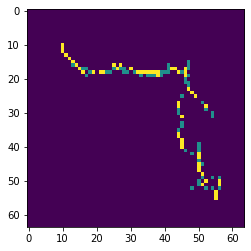

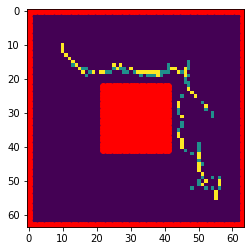

In [54]:
map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2).reshape(MAP_DIMS)
obs = np.argwhere(map==1)
# plt.imshow(map)
# plt.show()

label = 1
noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
fake = gen(noise, torch.tensor([label], dtype=torch.int32, device=device))
plt.imshow(np.round(fake.cpu().detach().numpy()[0][0]))
plt.show()

plt.imshow(np.round(fake.cpu().detach().numpy()[0][0]))
plt.scatter(obs[:, 1], obs[:, 0], c='r')                # looks a little more thiccy than obstacles in actual map
plt.show()



[1. 0.]
[[1.         0.        ]
 [0.98989899 0.01010101]
 [0.97979798 0.02020202]
 [0.96969697 0.03030303]
 [0.95959596 0.04040404]
 [0.94949495 0.05050505]
 [0.93939394 0.06060606]
 [0.92929293 0.07070707]
 [0.91919192 0.08080808]
 [0.90909091 0.09090909]
 [0.8989899  0.1010101 ]
 [0.88888889 0.11111111]
 [0.87878788 0.12121212]
 [0.86868687 0.13131313]
 [0.85858586 0.14141414]
 [0.84848485 0.15151515]
 [0.83838384 0.16161616]
 [0.82828283 0.17171717]
 [0.81818182 0.18181818]
 [0.80808081 0.19191919]
 [0.7979798  0.2020202 ]
 [0.78787879 0.21212121]
 [0.77777778 0.22222222]
 [0.76767677 0.23232323]
 [0.75757576 0.24242424]
 [0.74747475 0.25252525]
 [0.73737374 0.26262626]
 [0.72727273 0.27272727]
 [0.71717172 0.28282828]
 [0.70707071 0.29292929]
 [0.6969697  0.3030303 ]
 [0.68686869 0.31313131]
 [0.67676768 0.32323232]
 [0.66666667 0.33333333]
 [0.65656566 0.34343434]
 [0.64646465 0.35353535]
 [0.63636364 0.36363636]
 [0.62626263 0.37373737]
 [0.61616162 0.38383838]
 [0.60606061 0.39

/tmp/ipykernel_10643/835384611.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  fake.append(gen(noise, torch.tensor([i[0]], dtype=torch.int32, device=device)))


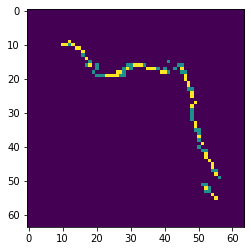

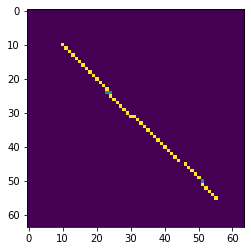

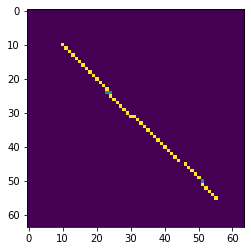

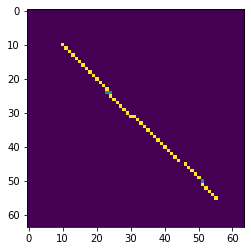

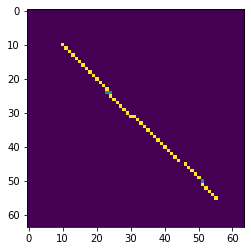

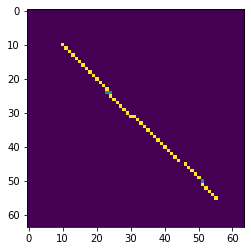

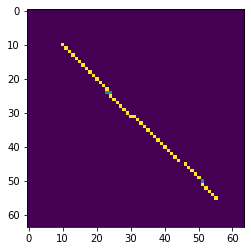

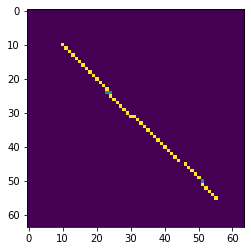

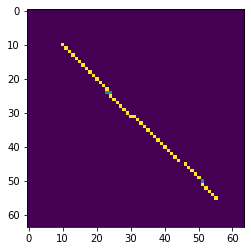

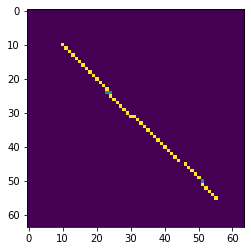

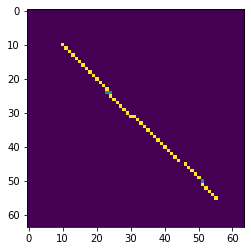

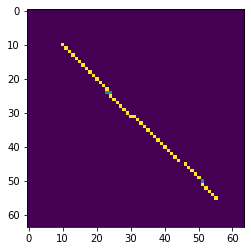

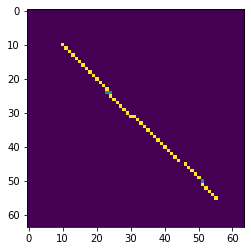

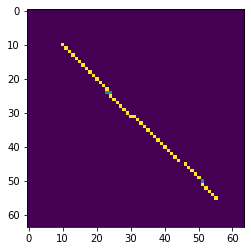

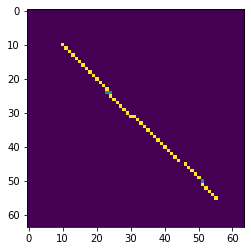

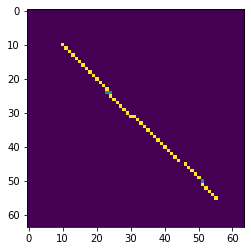

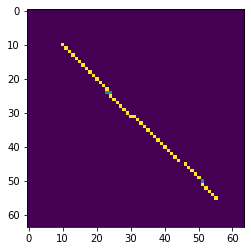

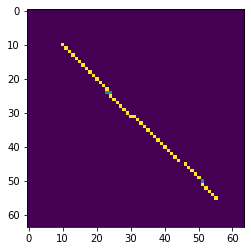

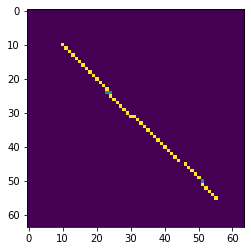

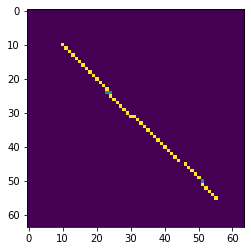

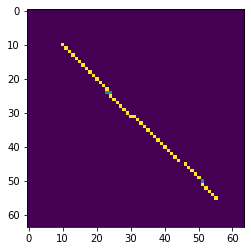

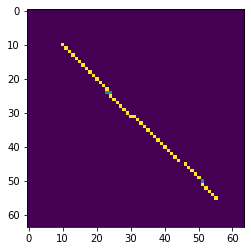

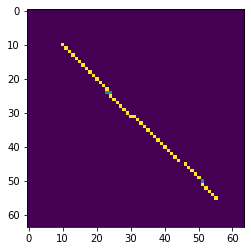

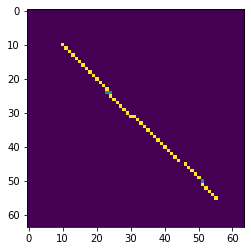

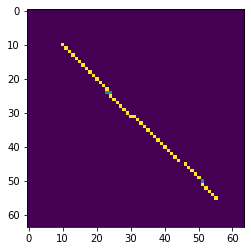

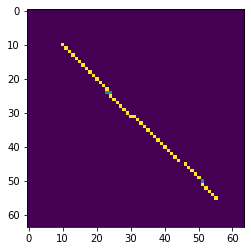

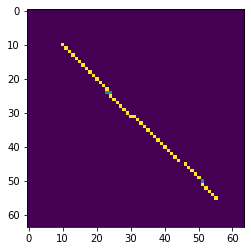

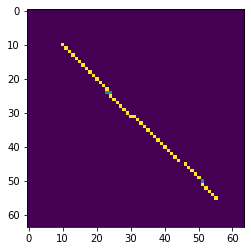

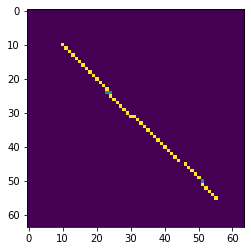

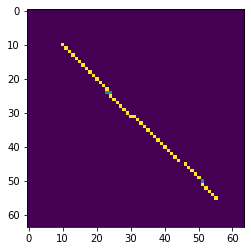

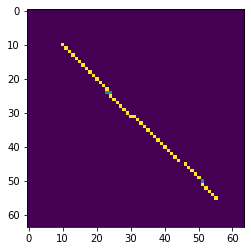

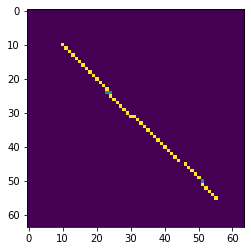

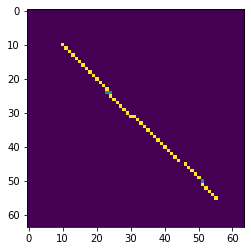

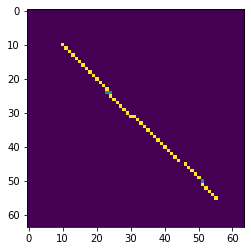

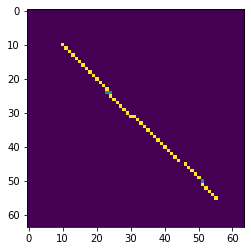

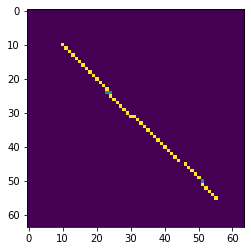

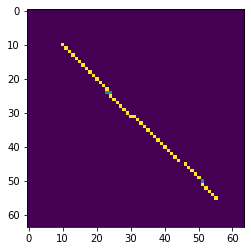

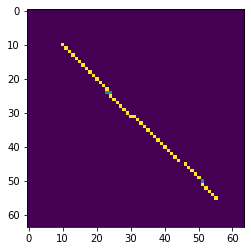

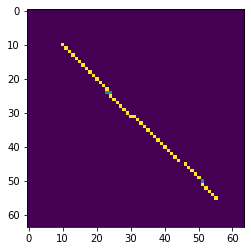

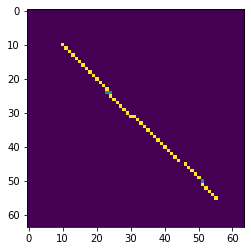

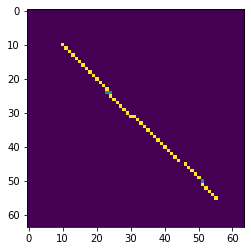

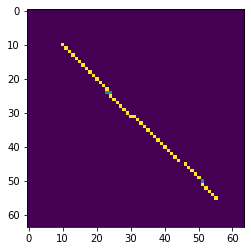

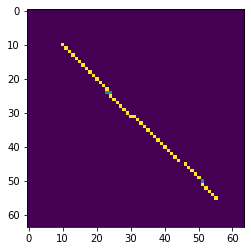

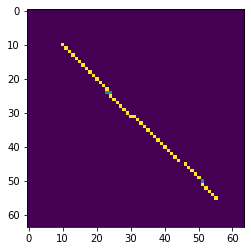

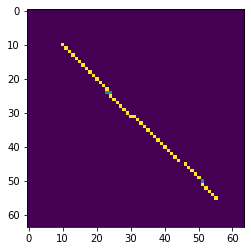

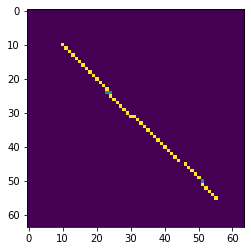

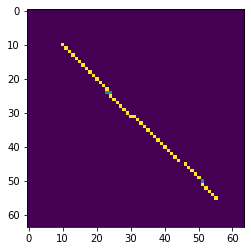

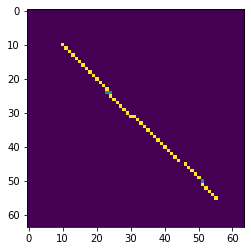

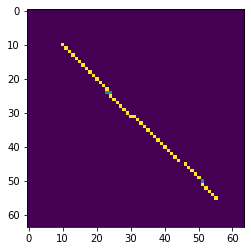

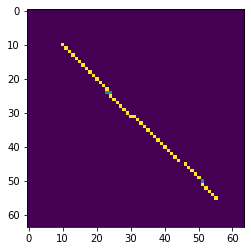

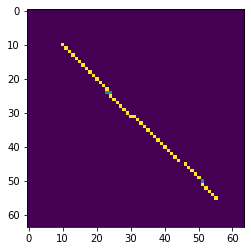

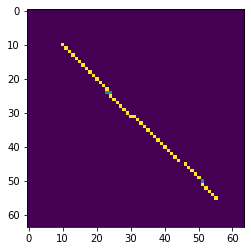

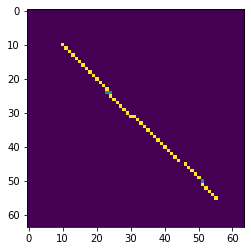

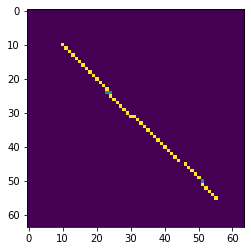

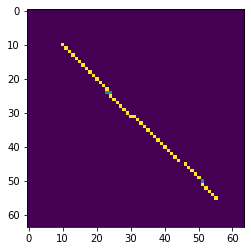

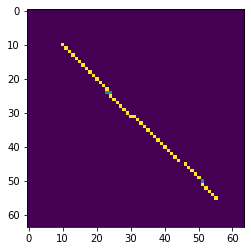

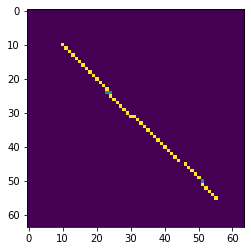

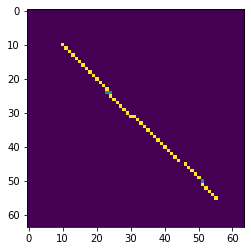

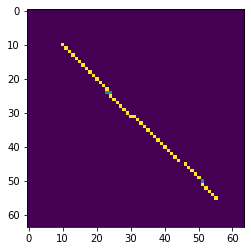

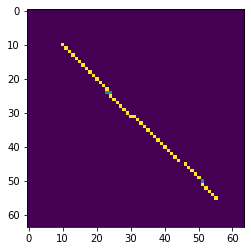

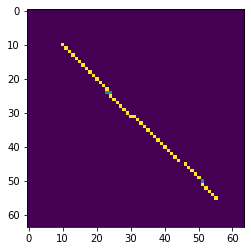

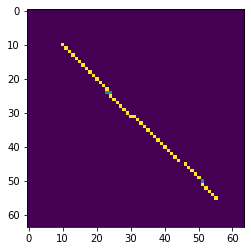

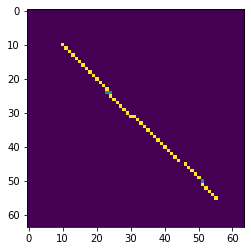

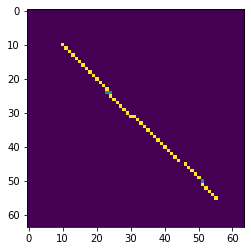

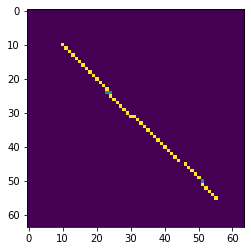

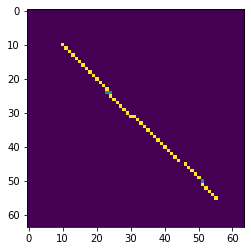

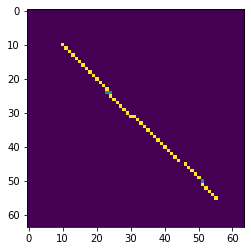

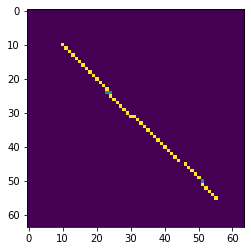

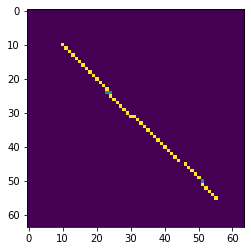

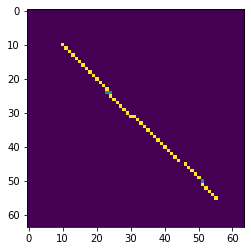

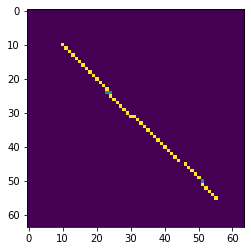

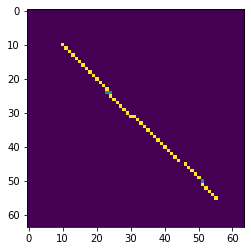

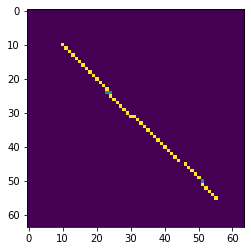

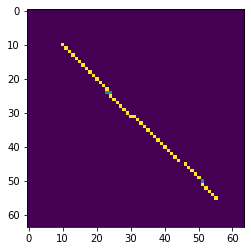

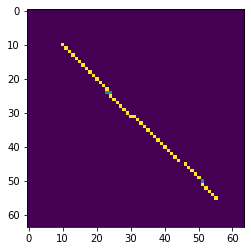

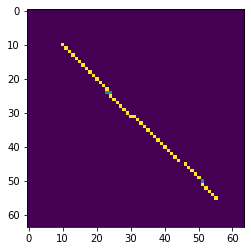

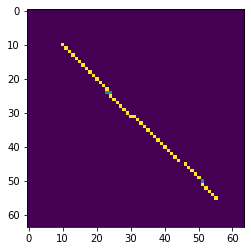

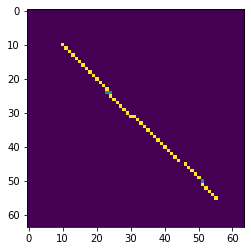

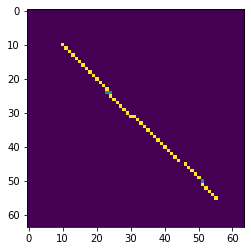

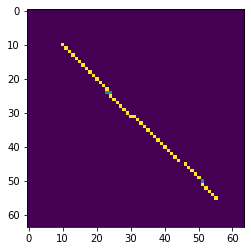

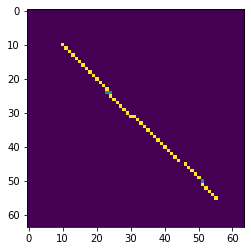

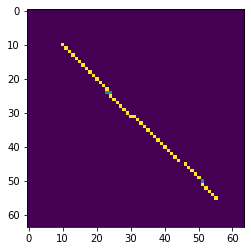

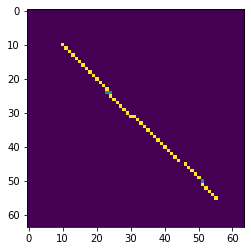

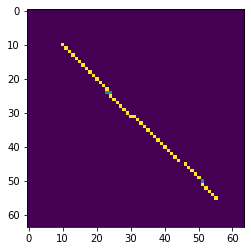

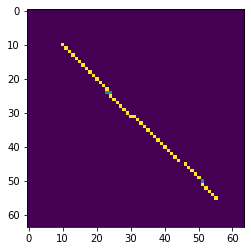

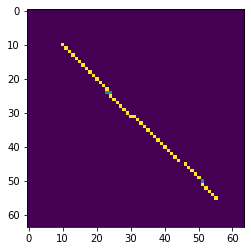

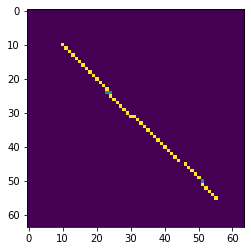

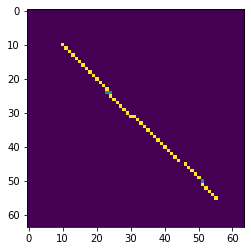

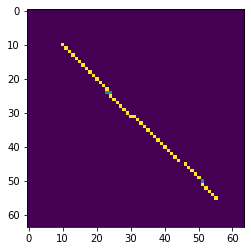

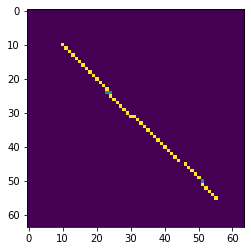

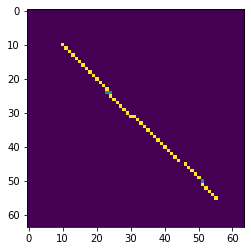

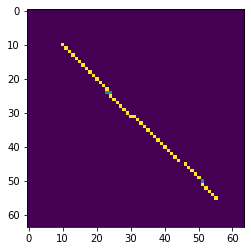

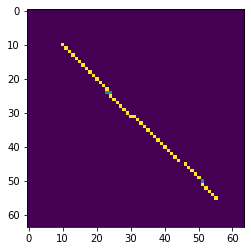

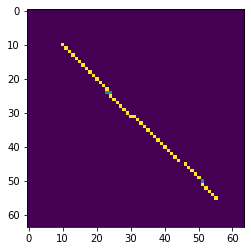

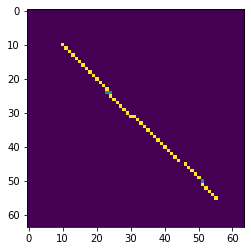

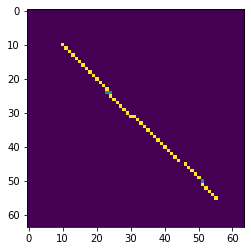

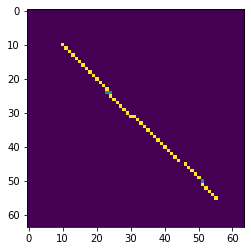

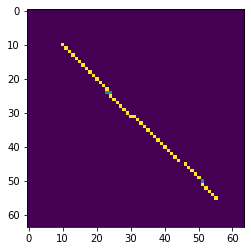

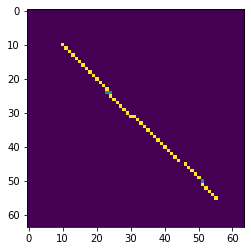

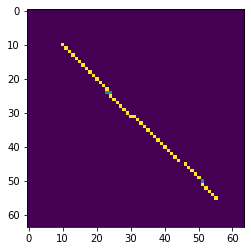

In [66]:
def interpolate_class(first_number, second_number, num_interpolation):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = np.eye(2)[first_number]
    second_label = np.eye(2)[second_number]
    print(first_label)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = np.linspace(0, 1, num_interpolation)[:, None]
    # percent_second_label = np.cast(percent_second_label, np.float32)
    # print(percent_second_label)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )
    print(interpolation_labels)

    # Combine the noise and the labels and run inference with the generator.
    # noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = []
    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    for i in interpolation_labels:
        # noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
        fake.append(gen(noise, torch.tensor([i[0]], dtype=torch.float32, device=device)))
    return fake


fake = interpolate_class(0, 1, 100)

for i in fake:
    plt.imshow(np.round(i.cpu().detach().numpy()[0][0]))
    plt.show()